## Setup

In [79]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from pdb import set_trace as st
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import Adam, SGD
from utils import *

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [81]:
class CharDataset(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label
    
def get_dataloaders(num_classes=50, num_samples_train=15, num_samples_test=5):
    x_train, y_train, x_test, y_test = LoadData(num_classes, num_samples_train, num_samples_test)
    train_ds = CharDataset(x_train, y_train)
    test_ds = CharDataset(x_test, y_test)
    train_dl = DataLoader(train_ds, batch_size=64)
    test_dl = DataLoader(test_ds, batch_size=64)
    return train_dl, test_dl

In [82]:
num_classes = 50
num_samples_train = 15
num_samples_test = 5
train_dl, test_dl = get_dataloaders(num_classes, num_samples_train, num_samples_test)

In [28]:
def test_model(model):
    model.eval()
    y_preds = []
    ys = []
    for x, y in test_dl:
        x = x.to(device)
        y = y.to(device)
        y_pred = torch.max(model(x), 1)[1]
        y_preds.append(y_pred)
        ys.append(y)
    y_pred = torch.cat(y_preds).cpu()
    y = torch.cat(ys).cpu()
    return f1_score(y, y_pred, average='macro'), torch.sum(y == y_pred).item() / len(y)

In [67]:
def train_model(model, epochs, optimizer, silent=False):
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    f1s = []
    accs = []
    
    for epoch in range(epochs):
        if not silent:
            print(f'Epoch {epoch}/{epochs} at {datetime.now()}==========')
        
        model.train()
        total_iter_loss = 0
        for x, y in train_dl:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_pred_probs = model(x)
            loss = criterion(y_pred_probs, y)
            total_iter_loss += loss
            loss.backward()
            optimizer.step()
        
        losses.append(total_iter_loss.cpu().detach().numpy().item())
        if not silent:
            print(f'Training loss was {total_iter_loss / len(train_dl)}')
        
        f1, acc = test_model(model)
        f1s.append(f1)
        accs.append(acc)
        if not silent:
            print(f'Tested with F1={f1} and acc={acc}')

    return losses, f1s, accs

## Models

In [92]:
class FeedforwardModel(nn.Module):
    def __init__(self, dropout=0.2):
        super(FeedforwardModel, self).__init__()
        
        self.l1 = nn.Linear(784, 256)
        self.drop = nn.Dropout(dropout)
        self.bnorm = nn.BatchNorm1d(256)
        self.activation = nn.ReLU()
        self.l2 = nn.Linear(256, 50)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.l1(x)
        x = self.drop(x)
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.l2(x)
        x = self.softmax(x)
        return x


In [84]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 50)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.permute([1,0])[:,:,None]
        x = torch.stack([x,x,x], dim=1) # increase num channels to 3 as expected by resnet
        x = x.permute([2,1,0,3])
        x = self.resnet18(x)
        x = self.softmax(x)
        return x

In [85]:
ffnn = FeedforwardModel()
ffnn.to(device)
cnn = CNN()
cnn.to(device)
print('ok')

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ok


In [51]:
print(test_model(ffnn))
print(test_model(cnn))

(0.012711992697967453, 0.024)
(0.0008583690987124463, 0.02)


In [56]:
ff_optim = SGD(ffnn.parameters(), lr=1)
ff_results = train_model(ffnn, 50, ff_optim)


Epoch 0/50 at 2022-12-17 08:06:26.559929==========
Training loss was 3.9106268882751465
Tested with F1=0.026860512913144494 and acc=0.048
Epoch 1/50 at 2022-12-17 08:06:26.656935==========
Training loss was 3.8956527709960938
Tested with F1=0.01079124579124579 and acc=0.052
Epoch 2/50 at 2022-12-17 08:06:26.733967==========
Training loss was 3.860665798187256
Tested with F1=0.02367670770448668 and acc=0.084
Epoch 3/50 at 2022-12-17 08:06:26.812963==========
Training loss was 3.8158459663391113
Tested with F1=0.052154050154050155 and acc=0.124
Epoch 4/50 at 2022-12-17 08:06:26.878968==========
Training loss was 3.7713799476623535
Tested with F1=0.06321148167138975 and acc=0.136
Epoch 5/50 at 2022-12-17 08:06:26.916969==========
Training loss was 3.725656032562256
Tested with F1=0.10361193778827747 and acc=0.184
Epoch 6/50 at 2022-12-17 08:06:26.952967==========
Training loss was 3.673837184906006
Tested with F1=0.14447792849278918 and acc=0.224
Epoch 7/50 at 2022-12-17 08:06:26.989969==

In [57]:
c_optim = SGD(cnn.parameters(), lr=1)
c_results = train_model(cnn, 50, c_optim)

Epoch 0/50 at 2022-12-17 08:06:39.563463==========
Training loss was 3.9061245918273926
Tested with F1=0.000784313725490196 and acc=0.02
Epoch 1/50 at 2022-12-17 08:06:44.616116==========
Training loss was 3.8915328979492188
Tested with F1=0.002299077733860343 and acc=0.028
Epoch 2/50 at 2022-12-17 08:06:49.331957==========
Training loss was 3.8648905754089355
Tested with F1=0.01960920125626008 and acc=0.052
Epoch 3/50 at 2022-12-17 08:06:54.299735==========
Training loss was 3.858522891998291
Tested with F1=0.026737711461115712 and acc=0.056
Epoch 4/50 at 2022-12-17 08:06:59.568737==========
Training loss was 3.817808151245117
Tested with F1=0.05189887154344986 and acc=0.112
Epoch 5/50 at 2022-12-17 08:07:05.088785==========
Training loss was 3.781294345855713
Tested with F1=0.07794220194220194 and acc=0.152
Epoch 6/50 at 2022-12-17 08:07:10.724053==========
Training loss was 3.7432241439819336
Tested with F1=0.07687893749814396 and acc=0.132
Epoch 7/50 at 2022-12-17 08:07:16.547007==

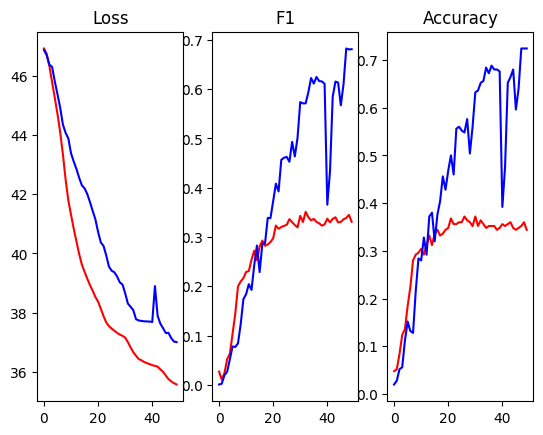

In [64]:
plt.subplot(1,3,1)
plt.plot(ff_results[0], 'r')
plt.plot(c_results[0], 'b')
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(ff_results[1], 'r')
plt.plot(c_results[1], 'b')
plt.title('F1')
plt.subplot(1,3,3)
plt.plot(ff_results[2], 'r')
plt.plot(c_results[2], 'b')
plt.title('Accuracy')
plt.show()

## Different training set sizes

In [86]:
results = []
for n_samples_train in [1, 3, 5, 10, 15]:
    train_dl, test_dl = get_dataloaders(num_classes, n_samples_train, num_samples_test)
    cnn = CNN()
    cnn.to(device)
    c_optim = SGD(cnn.parameters(), lr=1)
    c_results = train_model(cnn, 100, c_optim, silent=True)
    results.append(c_results)

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:

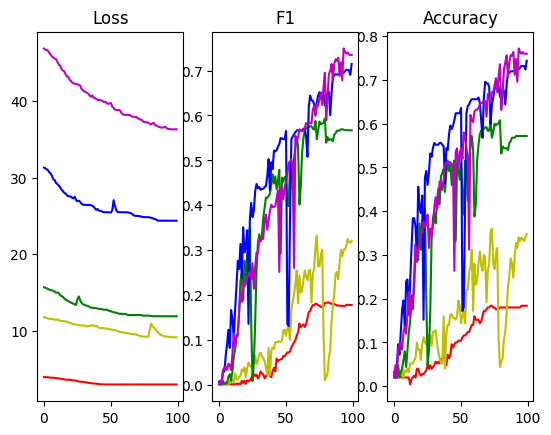

In [87]:
train_dl, test_dl = get_dataloaders(num_classes, num_samples_train, num_samples_test)
colors = ['r', 'y', 'g', 'b', 'm']
plt.subplot(1,3,1)
for i in range(5):
    plt.plot(results[i][0], colors[i])
plt.title('Loss')
plt.subplot(1,3,2)
for i in range(5):
    plt.plot(results[i][1], colors[i])
plt.title('F1')
plt.subplot(1,3,3)
for i in range(5):
    plt.plot(results[i][2], colors[i])
plt.title('Accuracy')
plt.show()

In [88]:
list(map(lambda rtriplet: list(map(lambda rarr: rarr[-1], rtriplet)), results))

[[2.9467101097106934, 0.17761140493493435, 0.184],
 [9.100447654724121, 0.3206238761238761, 0.348],
 [11.864006996154785, 0.5669255260868165, 0.572],
 [24.348018646240234, 0.7147450327450328, 0.744],
 [36.298736572265625, 0.7349599289599289, 0.76]]

## Different learning rates

In [89]:
results = []
for lr in [0.0625, 0.25, 1, 4, 16]:
    cnn = CNN()
    cnn.to(device)
    c_optim = SGD(cnn.parameters(), lr=lr)
    c_results = train_model(cnn, 100, c_optim, silent=True)
    results.append(c_results)

C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thisi\Documents\GitHub\bdi-hw1\env\lib\site-packages\torchvision\models\_utils.py:

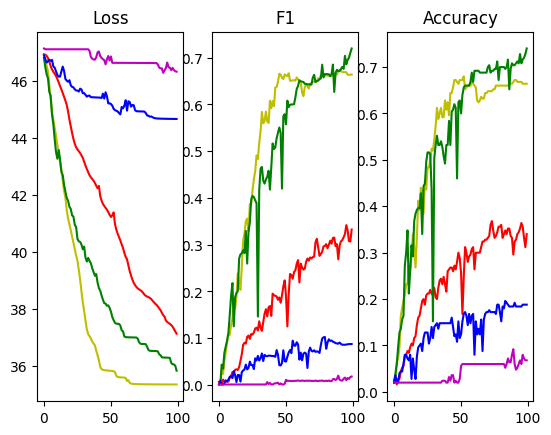

In [90]:
colors = ['r', 'y', 'g', 'b', 'm']
plt.subplot(1,3,1)
for i in range(5):
    plt.plot(results[i][0], colors[i])
plt.title('Loss')
plt.subplot(1,3,2)
for i in range(5):
    plt.plot(results[i][1], colors[i])
plt.title('F1')
plt.subplot(1,3,3)
for i in range(5):
    plt.plot(results[i][2], colors[i])
plt.title('Accuracy')
plt.show()

In [91]:
list(map(lambda rtriplet: list(map(lambda rarr: rarr[-1], rtriplet)), results))

[[37.13925552368164, 0.33224067762303056, 0.34],
 [35.356719970703125, 0.6637592407592408, 0.664],
 [35.839664459228516, 0.7195747118378698, 0.74],
 [44.66568374633789, 0.08726963241436925, 0.188],
 [46.32386779785156, 0.017828821137091812, 0.068]]

## Different dropouts (for FFNN)

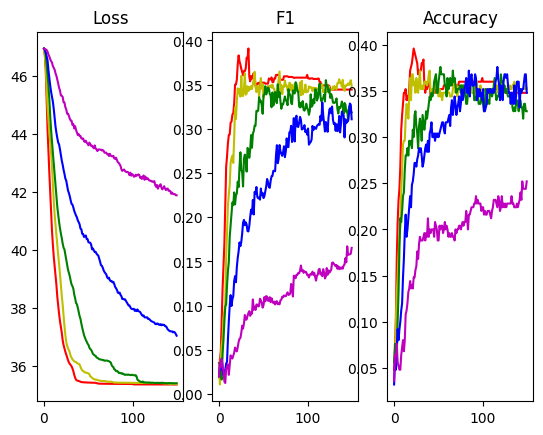

[[35.369293212890625, 0.34444383394383393, 0.348],
 [35.38709259033203, 0.34821858361796443, 0.352],
 [35.41371154785156, 0.3186038406038406, 0.328],
 [37.050472259521484, 0.31084965034965034, 0.348],
 [41.886592864990234, 0.1652796552604602, 0.252]]

In [96]:
results = []
for drop in [0, 0.2, 0.4, 0.6, 0.8]:
    ffnn = FeedforwardModel(dropout=drop)
    ffnn.to(device)
    ff_optim = SGD(ffnn.parameters(), lr=1)
    ff_results = train_model(ffnn, 150, ff_optim, silent=True)
    results.append(ff_results)
    
colors = ['r', 'y', 'g', 'b', 'm']
plt.subplot(1,3,1)
for i in range(5):
    plt.plot(results[i][0], colors[i])
plt.title('Loss')
plt.subplot(1,3,2)
for i in range(5):
    plt.plot(results[i][1], colors[i])
plt.title('F1')
plt.subplot(1,3,3)
for i in range(5):
    plt.plot(results[i][2], colors[i])
plt.title('Accuracy')
plt.show()
list(map(lambda rtriplet: list(map(lambda rarr: rarr[-1], rtriplet)), results))